In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import progressbar

import os

from surprise import Reader, Dataset
from surprise.model_selection import train_test_split, cross_validate

from sklearn.metrics.pairwise import linear_kernel

import pickle

# Découverte du jeu de données

Signification des champs de **Articles_metadata** (selon mon interprétation) :

- **article_id** : identifiant unique attribué à chaque article.
- **category_id** : identifiant de la catégorie de l’article, avec un total de 461 catégories distinctes.
- **created_at_ts** : horodatage indiquant la date et l'heure de création de l'article. Il convient de retirer les trois derniers chiffres. L'article le plus ancien a été créé le 27/09/2006 à 11:14:35 et le plus récent le 13/03/2018 à 12:12:30.
- **publisher_id** : semble inactif ou non renseigné, uniquement composé de 0.
- **words_count** : nombre de mots dans l’article, allant de 0 (probablement une anomalie) à 6690. Une distribution des valeurs est disponible dans certaines cellules.


In [25]:
articles_metadata = pd.read_csv('../data/news-portal-user-interactions-by-globocom/articles_metadata.csv')  
articles_metadata

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162
...,...,...,...,...,...
364042,364042,460,1434034118000,0,144
364043,364043,460,1434148472000,0,463
364044,364044,460,1457974279000,0,177
364045,364045,460,1515964737000,0,126


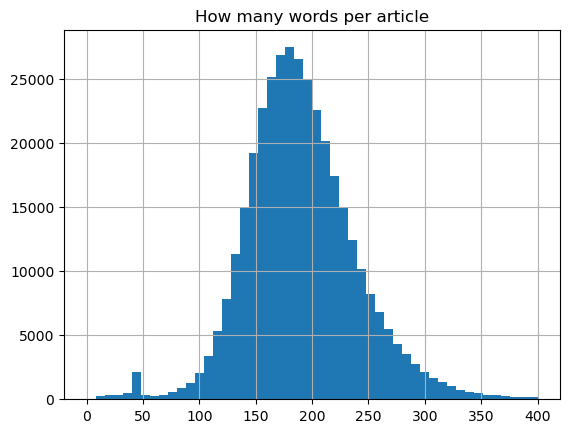

In [26]:
articles_metadata.words_count.hist(bins=50, range=(0,400))
plt.title('How many words per article');

Signification des **Clicks_hours**

- **user_id** : Identifiant unique pour chaque utilisateur.
- **session_id** : Identifiant unique pour chaque session d'un utilisateur. Ce champ peut apparaître plusieurs fois en raison de plusieurs clics au cours d'une même session.
- **session_start** : Horodatage de début de la session. Il est nécessaire de supprimer les trois derniers chiffres. La session la plus ancienne date du **2017/10/01 02:37:03** et la plus récente du **2017/10/01 03:39:19**.
- **session_size** : Nombre de clics réalisés au cours d'une session. Cela varie de **2 à 24** clics. Une distribution de ces tailles est disponible dans les cellules ci-dessous.
- **click_article_id** : Identifiant de l'article sur lequel l'utilisateur a cliqué.
- **click_environment** : Il s'agit probablement de l'origine de l'interaction, que ce soit via le site web ou l'application. Il y a seulement trois types, avec le type 4 représentant plus de 90 % des cas.
- **click_deviceGroup** : Type d'appareil utilisé : ordinateur, smartphone ou tablette.
- **click_os** : Système d'exploitation de l'appareil utilisé.
- **click_country** : Pays d'origine de l'utilisateur.
- **click_region** : Région d'origine de l'utilisateur.
- **click_referrer_type** : Nature de la référence, il faudrait davantage d'informations pour en déterminer la signification exacte.


In [27]:
clicks_hour_000 = pd.read_csv('../data/news-portal-user-interactions-by-globocom/clicks/clicks/clicks_hour_000.csv')  
clicks_hour_000

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1878,705,1506828968165442,1506828968000,2,119592,1506830912301,4,1,17,1,21,2
1879,705,1506828968165442,1506828968000,2,284847,1506830942301,4,1,17,1,21,2
1880,706,1506828979881443,1506828979000,3,108854,1506829027334,4,3,2,1,25,1
1881,706,1506828979881443,1506828979000,3,96663,1506829095732,4,3,2,1,25,1


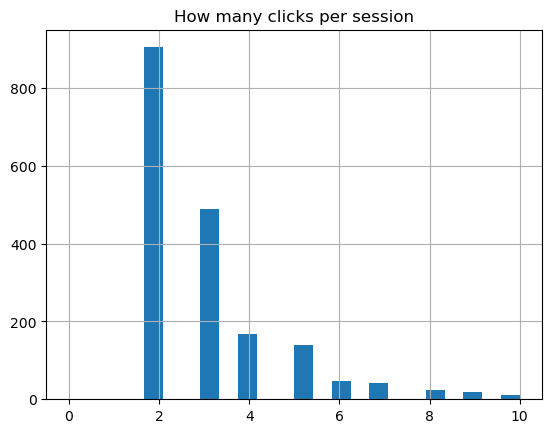

In [28]:
clicks_hour_000.session_size.hist(bins=24, range=(0,10))
plt.title('How many clicks per session');

In [29]:
clicks_hour_000.loc[clicks_hour_000.user_id == 0]

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2


In [30]:
clicks_hour_000.loc[clicks_hour_000.session_id == 1506828979881443]

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
1880,706,1506828979881443,1506828979000,3,108854,1506829027334,4,3,2,1,25,1
1881,706,1506828979881443,1506828979000,3,96663,1506829095732,4,3,2,1,25,1
1882,706,1506828979881443,1506828979000,3,68866,1506829125732,4,3,2,1,25,1


In [31]:
clicks_hour_000.isnull().sum()

user_id                0
session_id             0
session_start          0
session_size           0
click_article_id       0
click_timestamp        0
click_environment      0
click_deviceGroup      0
click_os               0
click_country          0
click_region           0
click_referrer_type    0
dtype: int64

In [32]:
clicks_hour_000[clicks_hour_000.duplicated()]

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type


# Content-Based Recommender Systems

## Préparation des données

In [ ]:
# Répertoire contenant les fichiers CSV
directory = '../data/news-portal-user-interactions-by-globocom/clicks/clicks/'

# Initialiser une liste pour stocker les DataFrames
dataframes = []

# Parcourir tous les fichiers dans le répertoire
for filename in os.listdir(directory):
    if filename.endswith('.csv'):  # Vérifier si le fichier est un CSV
        file_path = os.path.join(directory, filename)  # Construire le chemin complet du fichier
        df = pd.read_csv(file_path)  # Lire le fichier CSV dans un DataFrame
        dataframes.append(df)  # Ajouter le DataFrame à la liste

# Combiner tous les DataFrames en un seul
clicks = pd.concat(dataframes, ignore_index=True)

In [ ]:
clicks_tests = pd.read_csv('../data/news-portal-user-interactions-by-globocom/clicks.csv')
clicks_tests

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2988177,322896,1508211376302329,1508211376000,2,30760,1508211672520,4,1,17,1,25,2
2988178,322896,1508211376302329,1508211376000,2,157507,1508211702520,4,1,17,1,25,2
2988179,123718,1508211379189330,1508211379000,2,234481,1508211513583,4,3,2,1,25,2
2988180,123718,1508211379189330,1508211379000,2,233578,1508211543583,4,3,2,1,25,2


In [ ]:
clicks

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2988176,10051,1508211372158328,1508211372000,2,84911,1508211557302,4,3,2,1,25,1
2988177,322896,1508211376302329,1508211376000,2,30760,1508211672520,4,1,17,1,25,2
2988178,322896,1508211376302329,1508211376000,2,157507,1508211702520,4,1,17,1,25,2
2988179,123718,1508211379189330,1508211379000,2,234481,1508211513583,4,3,2,1,25,2


In [ ]:
clicks.loc[clicks["user_id"] == 0]


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
1287361,0,1507340000920377,1507340000000,2,96755,1507340033155,4,3,20,1,20,2
1287362,0,1507340000920377,1507340000000,2,313996,1507340063155,4,3,20,1,20,2
1352197,0,1507385847186982,1507385847000,2,160158,1507388090915,4,3,20,1,20,2
1352198,0,1507385847186982,1507385847000,2,233470,1507388120915,4,3,20,1,20,2
1535240,0,1507514030209212,1507514030000,2,87224,1507514056617,4,3,20,1,20,2
1535241,0,1507514030209212,1507514030000,2,87205,1507514086617,4,3,20,1,20,2


In [ ]:
# Copier la première ligne du DataFrame
new_row = clicks.iloc[0].copy()

# Modifier la valeur de 'click_article_id'
new_row['click_article_id'] = 154313

# Ajouter la nouvelle ligne au DataFrame
clicks = clicks.append(new_row, ignore_index=True)

# Afficher le DataFrame mis à jour
print(clicks.tail())


In [ ]:
clicks.to_csv('combined_clicks.csv', index=False) 

In [ ]:
clicks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2988182 entries, 0 to 2988181
Data columns (total 12 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   user_id              object
 1   session_id           object
 2   session_start        object
 3   session_size         object
 4   click_article_id     object
 5   click_timestamp      object
 6   click_environment    object
 7   click_deviceGroup    object
 8   click_os             object
 9   click_country        object
 10  click_region         object
 11  click_referrer_type  object
dtypes: object(12)
memory usage: 273.6+ MB


Nous devons regrouper chaque clic d'article par utilisateur.

In [ ]:
df = clicks.groupby('user_id').agg(
    LIST_click_article_id = ('click_article_id', lambda x: list(x)),
)
df

,LIST_click_article_id
user_id,
0,"[157541, 68866, 96755, 313996, 160158, 233470,..."
1,"[235840, 96663, 59758, 160474, 285719, 156723,..."
2,"[119592, 30970, 30760, 209122]"
3,"[236065, 236294, 234686, 233769, 235665, 23513..."
4,"[48915, 44488, 195887, 195084, 63307, 336499, ..."
...,...
322892,"[42567, 39894]"
322893,"[50644, 36162]"
322894,"[36162, 168401]"


In [ ]:
if not os.path.exists('../data/p9-data/df.csv'):
        pbar = progressbar.ProgressBar(widgets=[progressbar.Percentage(), progressbar.Bar()], maxval=len(df)).start()
        
        df['categories'] = ''

        for index, row in df.iterrows():
            pbar.update(index)
            _list_row = []
            for article in row.LIST_click_article_id:
                _list_row.append(articles_metadata[articles_metadata.article_id == article].category_id.values[0])
            df.loc[index]['categories']=_list_row
        df.to_csv('df.csv')
        pbar.finish()
else:
    df= pd.read_csv('../data/p9-data/df.csv')

In [ ]:
df

,user_id,LIST_click_article_id,categories
0,0,"[157541, 68866, 96755, 313996, 160158, 233470,...","[281, 136, 209, 431, 281, 375, 186, 186]"
1,1,"[235840, 96663, 59758, 160474, 285719, 156723,...","[375, 209, 123, 281, 412, 281, 331, 412, 435, ..."
2,2,"[119592, 30970, 30760, 209122]","[247, 26, 26, 332]"
3,3,"[236065, 236294, 234686, 233769, 235665, 23513...","[375, 375, 375, 375, 375, 375, 281, 375, 375, ..."
4,4,"[48915, 44488, 195887, 195084, 63307, 336499, ...","[92, 81, 317, 317, 132, 437, 399]"
...,...,...,...
322892,322892,"[42567, 39894]","[67, 66]"
322893,322893,"[50644, 36162]","[99, 43]"
322894,322894,"[36162, 168401]","[43, 297]"
322895,322895,"[289197, 63746]","[418, 133]"


Nous avons maintenant les article_id et category_id sur lesquels les utilisateurs ont cliqué.

## Calcul du nombre de clics par utilisateur.

Combien de fois un utilisateur a-t-il cliqué sur un article de la catégorie Y ?

In [ ]:
def inputUserRatings(userId):
    _matrix = pd.DataFrame(columns=['click'])
    _row = df.loc[userId]['categories']
    _row = _row.replace('[', '').replace(']', '').replace(',', '').split()
    
    for index, val in pd.Series(_row).value_counts().items():
        _matrix.loc[index] = int(val)
         
    _matrix['click_norm'] = _matrix.apply(lambda x : x / _matrix['click'].max())
    _matrix = _matrix.reset_index()
    _matrix = _matrix.rename(columns={"index": "category_id"})
    _matrix['category_id'] = _matrix['category_id'].astype(int)
    
    return _matrix

In [ ]:
inputUserRatings(0)

,category_id,click,click_norm
0,281,2,1.0
1,186,2,1.0
2,136,1,0.5
3,209,1,0.5
4,431,1,0.5
5,375,1,0.5


## Recommandation des livres parmi les 360 000 livres disponibles en fonction de la category_id préférée

In [ ]:
articles_matrix = articles_metadata.loc[:, ['article_id', 'category_id']]
display(articles_matrix.dtypes)

article_id     int64
category_id    int64
dtype: object

In [ ]:
def recommend5(userId, articles_matrix):
    _input_user_ratings = inputUserRatings(userId)
    _articles_matrix = articles_matrix
    
    _weighed_articles_matrix = pd.DataFrame(columns=['article_id', 'category_id', 'weight'])
    _weighed_articles_matrix['article_id'] = _articles_matrix['article_id']
    _weighed_articles_matrix['category_id'] = _articles_matrix['category_id']
    #display(_weighed_articles_matrix.dtypes)

    _weighed_articles_matrix['weight'] = _weighed_articles_matrix['category_id'].apply(lambda x :
                                                                                        0                                                                                           
                                                                                       if(_input_user_ratings.loc[_input_user_ratings['category_id'] == x].empty == True)
                                                                                       else
                                                                                        _input_user_ratings.loc[_input_user_ratings['category_id'] == x].click_norm.values[0]
                                                                                      )

    
    return _weighed_articles_matrix[_weighed_articles_matrix.weight > 0].sort_values(by=['weight'], ascending=False)

In [ ]:
%%time
res = recommend5(0 , articles_matrix)
res

CPU times: total: 40.5 s
Wall time: 1min 11s


,article_id,category_id,weight
158832,158832,281,1.0
154313,154313,281,1.0
154323,154323,281,1.0
154322,154322,281,1.0
154321,154321,281,1.0
...,...,...,...
95817,95817,209,0.5
95816,95816,209,0.5
95815,95815,209,0.5
95814,95814,209,0.5


Comme nous pouvons le voir, cela fonctionne mais cela prend trop de temps. Environ 2 minutes par utilisateur. Cela ne fonctionne que si l'utilisateur a peu d'interactions. Nous utiliserons le résultat de cet algorithme pour le comparer avec le prochain algorithme.

# Collabortative Filtering

## Préparation de la data

In [ ]:
clicks.head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


In [ ]:
articles_metadata.head()

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


In [ ]:
dataframe = clicks.merge(articles_metadata, left_on='click_article_id', right_on='article_id')

In [ ]:
dataframe = dataframe[['user_id', 'article_id', 'category_id']]
dataframe

,user_id,article_id,category_id
0,0,157541,281
1,0,68866,136
2,1,235840,375
3,1,96663,209
4,2,119592,247
...,...,...,...
2988176,10051,84911,174
2988177,322896,30760,26
2988178,322896,157507,281
2988179,123718,234481,375


In [ ]:
series = dataframe.groupby(['user_id', 'category_id']).size()
user_rating_matrix = series.to_frame()
user_rating_matrix = user_rating_matrix.reset_index()
user_rating_matrix.rename(columns = {0:'rate'}, inplace = True)

In [ ]:
user_rating_matrix

,user_id,category_id,rate
0,0,136,1
1,0,186,2
2,0,209,1
3,0,281,2
4,0,375,1
...,...,...,...
1882297,322894,297,1
1882298,322895,133,1
1882299,322895,418,1
1882300,322896,26,1


In [ ]:
reader = Reader(rating_scale=(1,10))
_x = user_rating_matrix.loc[user_rating_matrix.rate > 1]
data = Dataset.load_from_df(_x[['user_id', 'category_id', 'rate']], reader)

print('We have selects', len(_x), 'interactions.')

We have selects 503616 interactions.


## Utilisation de la bibliothèque "surprise"

In [ ]:
trainset, testset = train_test_split(data, test_size=0.25)
print('Test set lenght :', len(testset))
print('Train set lenght :', len(_x) - len(testset))

Test set lenght : 125904
Train set lenght : 377712


In [ ]:
from surprise import SVD, accuracy
algo = SVD()
algo.fit(trainset)

In [ ]:
predictions = algo.test(testset)
print('Number of predictions in Test set :', len(predictions))

Number of predictions in Test set : 125904


In [ ]:
# Afficher les 5 premières prédictions pour comprendre le contenu
for pred in predictions[:5]:
    print(f"User ID: {pred.uid}")
    print(f"Article ID: {pred.iid}")
    print(f"True Rating: {pred.r_ui}")
    print(f"Estimated Rating: {pred.est}")
    print(f"Details: {pred.details}")
    print("-" * 40)


User ID: 68747
Article ID: 265
True Rating: 2.0
Estimated Rating: 10
Details: {'was_impossible': False}
----------------------------------------
User ID: 146628
Article ID: 340
True Rating: 4.0
Estimated Rating: 10
Details: {'was_impossible': False}
----------------------------------------
User ID: 40119
Article ID: 186
True Rating: 2.0
Estimated Rating: 10
Details: {'was_impossible': False}
----------------------------------------
User ID: 99855
Article ID: 421
True Rating: 3.0
Estimated Rating: 10
Details: {'was_impossible': False}
----------------------------------------
User ID: 147983
Article ID: 209
True Rating: 2.0
Estimated Rating: 10
Details: {'was_impossible': False}
----------------------------------------


In [ ]:
len(predictions)

125904

In [ ]:
estimated_ratings_10 = [pred for pred in predictions if pred.est == 10]
print(f"Number of predictions with estimated rating = 10: {len(estimated_ratings_10)}")

Number of predictions with estimated rating = 10: 125893


In [ ]:
predictions

[Prediction(uid=68747, iid=265, r_ui=2.0, est=10, details={'was_impossible': False}),
 Prediction(uid=146628, iid=340, r_ui=4.0, est=10, details={'was_impossible': False}),
 Prediction(uid=40119, iid=186, r_ui=2.0, est=10, details={'was_impossible': False}),
 Prediction(uid=99855, iid=421, r_ui=3.0, est=10, details={'was_impossible': False}),
 Prediction(uid=147983, iid=209, r_ui=2.0, est=10, details={'was_impossible': False}),
 Prediction(uid=3576, iid=437, r_ui=7.0, est=10, details={'was_impossible': False}),
 Prediction(uid=213433, iid=136, r_ui=2.0, est=10, details={'was_impossible': False}),
 Prediction(uid=16452, iid=331, r_ui=5.0, est=10, details={'was_impossible': False}),
 Prediction(uid=100361, iid=412, r_ui=3.0, est=10, details={'was_impossible': False}),
 Prediction(uid=53040, iid=281, r_ui=2.0, est=10, details={'was_impossible': False}),
 Prediction(uid=135679, iid=437, r_ui=2.0, est=10, details={'was_impossible': False}),
 Prediction(uid=295056, iid=375, r_ui=2.0, est=10,

In [ ]:
accuracy.rmse(predictions)

RMSE: 7.4621


7.462139896074482

In [ ]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [ ]:
top_n = get_top_n(predictions, n=10)

In [ ]:
with open("top_n.txt", "wb") as fp:
    pickle.dump(top_n, fp)

In [ ]:
def findRecom(dic, userId):
    res = []
    query = dic[userId]
    for uid, user_ratings in query:
        res.append(uid)
    return res

In [ ]:
findRecom(top_n, 0)

[]

In [ ]:
result = findRecom(top_n, 0)
print(result)

[]


In [ ]:
res[['category_id', 'weight']].groupby('category_id').mean().sort_values('weight', ascending=False)

,weight
category_id,
186,1.0
281,1.0
136,0.5
209,0.5
375,0.5
431,0.5


In [ ]:
res.tail()

,article_id,category_id,weight
95817,95817,209,0.5
95816,95816,209,0.5
95815,95815,209,0.5
95814,95814,209,0.5
316736,316736,431,0.5


In [ ]:
# Supposons que 'top_n' soit le dictionnaire contenant les recommandations
user_id = 0

# Vérifier si l'utilisateur a des recommandations dans le dictionnaire
if user_id in top_n:
    recommendations_for_user_0 = top_n[user_id]
    print(f"Top N recommendations for user {user_id}:")
    for article_id, estimated_rating in recommendations_for_user_0:
        print(f"Article ID: {article_id}, Estimated Rating: {estimated_rating:.2f}")
else:
    print(f"No recommendations found for user {user_id}.")


Top N recommendations for user 0:


In [ ]:
max_rate = user_rating_matrix['rate'].max()
print(max_rate)

535


In [ ]:
# Basic descriptive statistics
user_rating_matrix['rate'].describe()


count    1.882302e+06
mean     1.587515e+00
std      1.921600e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      5.350000e+02
Name: rate, dtype: float64

In [ ]:
# Frequency of each rate value
user_rating_matrix['rate'].value_counts()

1      1378686
2       293326
3        97044
4        43989
5        23658
        ...   
84           1
103          1
156          1
113          1
138          1
Name: rate, Length: 127, dtype: int64

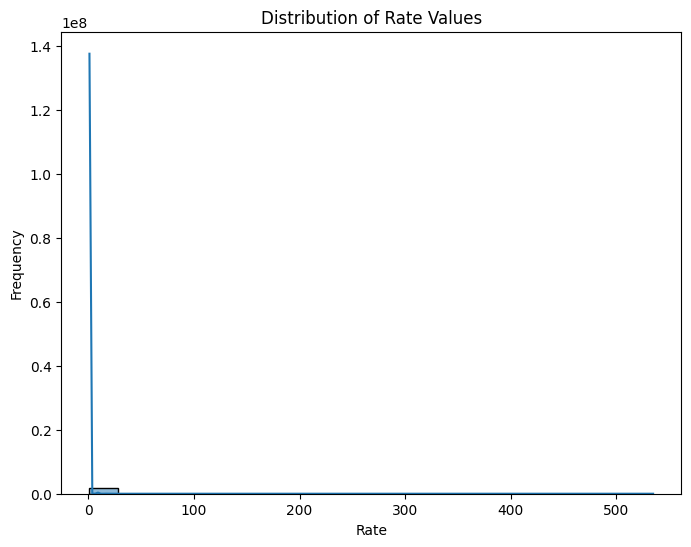

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.histplot(user_rating_matrix['rate'], bins=20, kde=True)
plt.title('Distribution of Rate Values')
plt.xlabel('Rate')
plt.ylabel('Frequency')
plt.show()


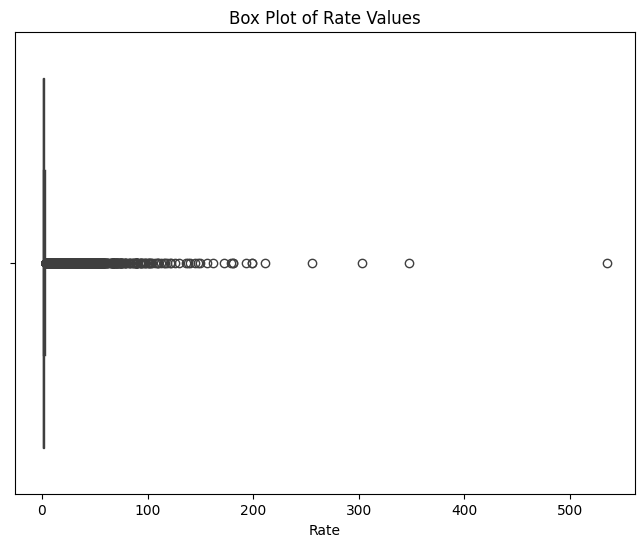

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=user_rating_matrix['rate'])
plt.title('Box Plot of Rate Values')
plt.xlabel('Rate')
plt.show()


In [ ]:
# Remove entries where rate is greater than 10
user_rating_matrix_cleaned = user_rating_matrix[user_rating_matrix['rate'] <= 10]

# Optionally, display the updated DataFrame to confirm changes
print(user_rating_matrix_cleaned)


         user_id  category_id  rate
0              0          136     1
1              0          186     2
2              0          209     1
3              0          281     3
4              0          375     1
...          ...          ...   ...
1882297   322894          297     1
1882298   322895          133     1
1882299   322895          418     1
1882300   322896           26     1
1882301   322896          281     1

[1871755 rows x 3 columns]


In [ ]:
reader = Reader(rating_scale=(1,10))
_x = user_rating_matrix_cleaned.loc[user_rating_matrix_cleaned.rate > 1]
data = Dataset.load_from_df(_x[['user_id', 'category_id', 'rate']], reader)

print('We have selects', len(_x), 'interactions.')

We have selects 493069 interactions.


In [ ]:
trainset, testset = train_test_split(data, test_size=0.25)
print('Test set lenght :', len(testset))
print('Train set lenght :', len(_x) - len(testset))

Test set lenght : 123268
Train set lenght : 369801


In [ ]:
from surprise import Dataset

# Obtenir le trainset complet
full_trainset = data.build_full_trainset()

# Construire un testset correspondant avec toutes les interactions possibles
full_testset = full_trainset.build_testset()

algo.fit(trainset)

# Faire des prédictions sur le testset complet
predictions_data = algo.test(full_testset)

# Afficher le nombre de prédictions sur l'ensemble des données
print('Number of predictions on the full dataset:', len(predictions_data))

Number of predictions on the full dataset: 493069


In [ ]:
# Enregistrer le modèle dans un fichier
with open('svd_model.pkl', 'wb') as model_file:
    pickle.dump(algo, model_file)

In [ ]:
predictions_data

[Prediction(uid=0, iid=186, r_ui=2.0, est=2.2491357037918367, details={'was_impossible': False}),
 Prediction(uid=0, iid=281, r_ui=3.0, est=2.2068902814245157, details={'was_impossible': False}),
 Prediction(uid=1, iid=281, r_ui=2.0, est=1.8233997844137233, details={'was_impossible': False}),
 Prediction(uid=1, iid=375, r_ui=2.0, est=1.8949706603697785, details={'was_impossible': False}),
 Prediction(uid=1, iid=412, r_ui=2.0, est=2.06705211578366, details={'was_impossible': False}),
 Prediction(uid=2, iid=26, r_ui=2.0, est=2.243664205650861, details={'was_impossible': False}),
 Prediction(uid=4, iid=317, r_ui=2.0, est=2.18106750967274, details={'was_impossible': False}),
 Prediction(uid=5, iid=43, r_ui=2.0, est=2.6045581461454357, details={'was_impossible': False}),
 Prediction(uid=5, iid=99, r_ui=3.0, est=2.3476338751115833, details={'was_impossible': False}),
 Prediction(uid=5, iid=118, r_ui=2.0, est=2.5342141084653567, details={'was_impossible': False}),
 Prediction(uid=5, iid=125, 

In [ ]:
accuracy.rmse(predictions_data)

RMSE: 1.0110


1.0110154650926515

In [ ]:
def get_top_n(predictions, n=5):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [ ]:
top_n = get_top_n(predictions_data, n=5)

In [ ]:
with open("top_n_final.txt", "wb") as fp:
    pickle.dump(top_n, fp)

In [ ]:
top_n

defaultdict(list,
            {0: [(186, 2.2491357037918367), (281, 2.2068902814245157)],
             1: [(412, 2.06705211578366),
              (375, 1.8949706603697785),
              (281, 1.8233997844137233)],
             2: [(26, 2.243664205650861)],
             4: [(317, 2.18106750967274)],
             5: [(125, 2.9208245519662426),
              (43, 2.6045581461454357),
              (118, 2.5342141084653567),
              (375, 2.501026341011423),
              (413, 2.408895270080722)],
             6: [(375, 4.813754789948124),
              (327, 4.097639974140868),
              (331, 3.407050951344912),
              (281, 3.183078195614754),
              (136, 2.542387524466263)],
             7: [(375, 2.9846326039836684),
              (412, 2.939035215168977),
              (281, 2.2255392845200834)],
             8: [(375, 5.62765959569111),
              (412, 4.136690464285055),
              (237, 3.8026649357791067),
              (209, 3.6289051639567194),

In [ ]:
def findRecom(dic, userId):
    res = []
    query = dic[userId]
    for uid, user_ratings in query:
        res.append(uid)
    return res

In [ ]:
findRecom(top_n, 0)

[186, 281]